# RICH AI Exploratory Data Analysis

Notes
- Labels are 0: Muon, 1: Pion, 2: Positron
- Likelihood labels are different [Pion, Muon, Positron]

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob

# Helper functions

In [2]:
def read_RICHAI_data(file_paths):
    """Read in all the 2018 RICHAI data
    
    Parameters
    ----------
    file_paths : list of str
        List of file paths of all data sets.
        
    Returns
    -------
    data_files : dict
        Dictionary of HFD data sets     
    """
    data_files = {}
    for file_path in file_paths:
        name = file_path.split("/")[4] + "/" + file_path.split("/")[5].split(".")[0]
        data_files[name] = h5py.File(file_path)
    
    return data_files

In [3]:
def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas"""
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    
    # TODO: check w/ TRIUMF if this is correct
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    
    df["label"] = labels
    
    return df

In [4]:
def get_string_label(label):
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    elif label == 2:
        return "positron"

In [5]:
file_paths = glob.glob("/data/bvelghe/capstone2022/*/*")
data_files = read_RICHAI_data(file_paths)
data_files.keys()

dict_keys(['A/Run008563', 'A/Run008548', 'A/Run008564', 'A/Run008553', 'A/Run008562', 'C/2018E', 'B/2018B'])

# DataFrame

In [6]:
df = events_to_pandas(data_files['A/Run008563'])
df["class"] = df["label"].apply(get_string_label)
df.head()

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,class
0,8563,1502,19187,0,29.086382,24.875072,181.268814,-4.406287,31.420258,1.229546e-08,1.0,9.656426e-02,0,muon
1,8563,1502,43695,0,29.131575,23.019239,180.360535,-33.380520,81.289101,2.874574e-05,1.0,1.647658e-09,0,muon
2,8563,1502,53258,0,53.725155,7.871216,187.981369,-124.974808,-26.034964,3.173104e-01,1.0,9.871307e-02,0,muon
3,8563,1502,79840,1,45.426033,15.969522,181.346909,-159.838486,-44.940845,1.382166e-01,1.0,2.374848e-01,0,muon
4,8563,1502,88854,0,51.754585,23.295773,186.581955,-131.870239,-39.216457,7.380376e-01,1.0,5.661391e-02,0,muon


In [7]:
# this matches Bob's documentation on https://github.com/TRIUMF-Capstone2022/RICHPID/tree/main/docs
df["class"].value_counts()

muon        162478
pion         17602
positron      1767
Name: class, dtype: int64

# Plots

## Distribution of track momentum for each particle

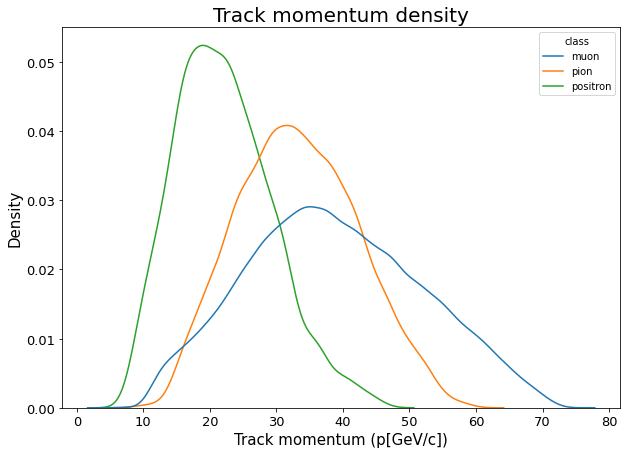

In [8]:
plt.figure(figsize=(10, 7))
sns.kdeplot(df["track_momentum"], hue=df["class"], common_norm=False, palette="tab10")
plt.title("Track momentum density", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

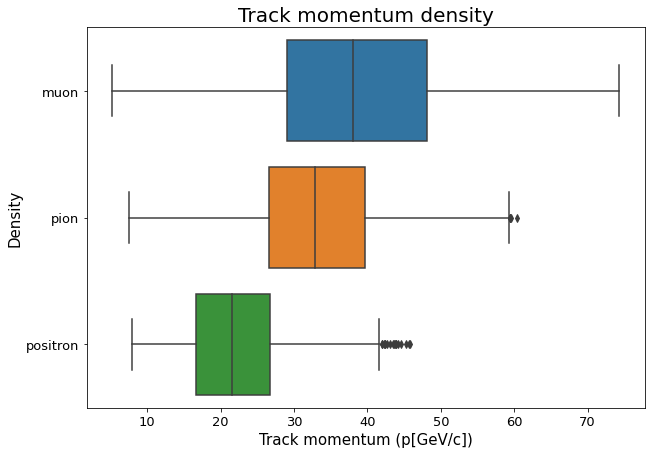

In [9]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="track_momentum", y="class", palette="tab10")
plt.title("Track momentum density", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Distribution of ring radius for each particle

<div class="alert alert-warning">
Some ring radius values are equal to 999,999 or greater, is this an error in the data?  See below:
</div>

In [10]:
df[df["ring_radius"] >= 999999.000]

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,class
99,8563,1502,1754876,0,9.472846,15.354265,999999.0,999999.0,999999.0,1.216099e-37,1.216099e-37,1.216099e-37,0,muon
418,8563,1505,1864199,1,45.689087,15.251482,999999.0,999999.0,999999.0,1.216099e-37,1.216099e-37,1.216099e-37,0,muon
2121,8563,1487,684736,1,55.891708,35.145298,999999.0,999999.0,999999.0,1.216099e-37,1.216099e-37,1.216099e-37,0,muon
2713,8563,1472,835945,1,36.513718,8.213794,999999.0,999999.0,999999.0,1.216099e-37,1.216099e-37,1.216099e-37,0,muon
3092,8563,1475,1228709,1,57.885632,32.871189,999999.0,999999.0,999999.0,1.216099e-37,1.216099e-37,1.216099e-37,0,muon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180800,8563,904,370741,0,19.951565,19.565580,999999.0,999999.0,999999.0,1.216099e-37,1.216099e-37,1.216099e-37,2,positron
180817,8563,889,1912114,0,31.217012,18.794067,999999.0,999999.0,999999.0,3.983476e-02,3.510035e-03,1.808248e-04,2,positron
180830,8563,881,1838906,0,16.281887,18.677586,999999.0,999999.0,999999.0,3.837442e-01,2.039289e-04,1.742545e-03,2,positron
181489,8563,315,847344,0,16.432795,23.136395,999999.0,999999.0,999999.0,1.216099e-37,1.216099e-37,1.216099e-37,2,positron


<div class="alert alert-warning">
There appears to be an outlier in this dataset, look at the radius, and centre values below:
</div>

In [11]:
df.iloc[158966]

run_id                             8563
burst_id                             40
event_id                         854840
track_id                              0
track_momentum                61.809074
chod_time                     23.413464
ring_radius                 1256322.875
ring_centre_pos_x          -1088155.625
ring_centre_pos_y            628279.625
ring_likelihood_pion             0.0961
ring_likelihood_muon           0.360728
ring_likelihood_positron            1.0
label                                 0
class                              muon
Name: 158966, dtype: object

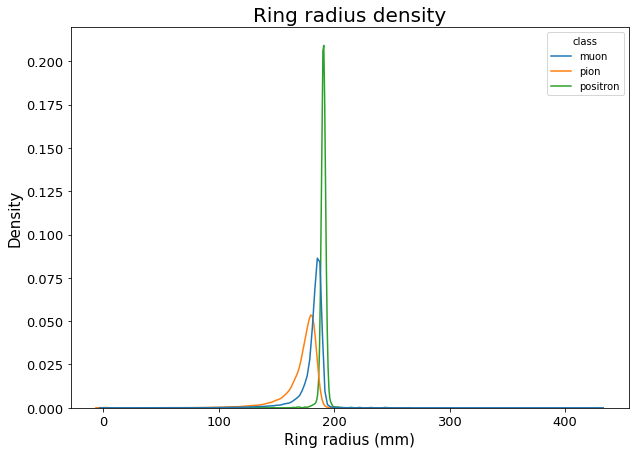

In [12]:
plt.figure(figsize=(10, 7))
sns.kdeplot(
    x=df.query("ring_radius < 999999.000")["ring_radius"],
    hue=df.query("ring_radius < 999999.000")["class"],
    common_norm=False,
    palette="tab10"
)
plt.title("Ring radius density", fontsize=20)
plt.xlabel("Ring radius (mm)", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Location of Ring Centres for Each Particle

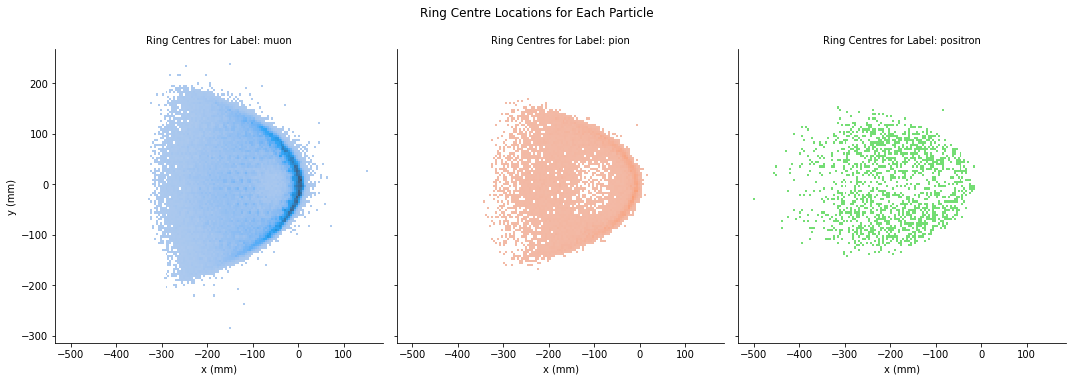

In [13]:
g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_x"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_y"],
    col=df.query("ring_centre_pos_y < 500000.000")["class"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    palette="tab10",
    legend=False
);

g.fig.set_figheight(5)
g.fig.set_figwidth(15)
g.set_axis_labels("x (mm)", "y (mm)")
g.set_titles("Ring Centres for Label: {col_name}")
g.tight_layout()
g.fig.suptitle("Ring Centre Locations for Each Particle", y=1.05)
plt.show()

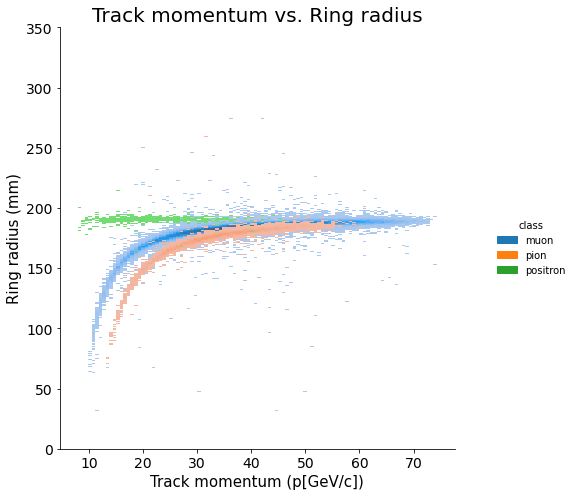

In [14]:
g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["track_momentum"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_radius"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    palette="tab10",
);


g.ax.set_title("Track momentum vs. Ring radius", fontsize=20)
g.set_axis_labels("Track momentum (p[GeV/c])", "Ring radius (mm)", fontsize=15)
g.set_titles("Ring Centres for Label: {col_name}")
g.ax.tick_params(axis='x', labelsize= 14)
g.ax.tick_params(axis='y', labelsize= 14)
g.ax.set_ylim([0, 350])    # some noise above 350 makes the plot ugly
g.fig.set_figheight(7)
g.fig.set_figwidth(8)
g.tight_layout()
plt.show()